In [8]:
import os
import cv2
import numpy as np

data_folder = "/public/home/xiaojx/age/age_estimation/data/utkface_aligned_cropped/UTKFace"
X_train = []
y_age_train = []

for filename in os.listdir(data_folder):
    if filename.endswith('.jpg'):
        # Extract the age
        age = filename[:-4].split('_')[0]
        # Load the image using OpenCV
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Append the image and age label to the lists
        X_train.append(image)
        y_age_train.append(int(age))

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_age_train = np.array(y_age_train)

# Print the shape of the arrays
print('Xtrain shape:', X_train.shape)
print('ytrain shape:', y_age_train.shape)

Xtrain shape: (23708, 200, 200, 3)
ytrain shape: (23708,)


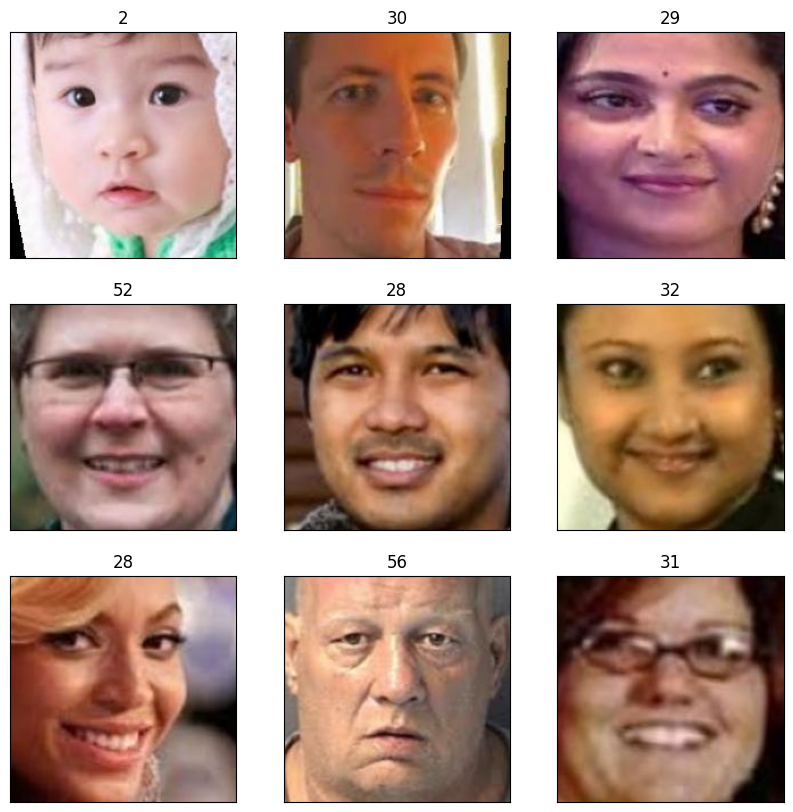

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
    x = np.random.randint(0, len(X_train))
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[x])
    plt.title(y_age_train[x])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [17]:
"""
create a new label named y_age_stage
Infant and Toddler: 0-3 years   class = 0
Preschooler and Kindergartener: 4-6 years  class = 1
child: 7-12 years class = 2
adolescent: 13-21 years class = 3
Adult in the prime : 22-37 years class = 4
Middle adult: 38-65 years class = 5
Elderly: 66-84 years class = 6
Oldest old: 85 years and older class = 7
"""
def map_age_stage(age):
    if age <= 3:
        return 0
    elif age <= 6:
        return 1
    elif age <= 12:
        return 2
    elif age <= 21:
        return 3
    elif age <= 37:
        return 4
    elif age <= 65:
        return 5
    elif age <= 84:
        return 6
    else:
        return 7

y_stage_train = np.array([map_age_stage(age) for age in y_age_train])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_stage_train, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (20151, 200, 200, 3)
Train labels shape:  (20151,)
Validation data shape:  (2845, 200, 200, 3)
Validation labels shape:  (2845,)
Test data shape:  (712, 200, 200, 3)
Test labels shape:  (712,)


In [19]:
mask = np.random.choice(len(X_train), 500, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [20]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (20151, 120000)
Validation data shape:  (2845, 120000)
Test data shape:  (712, 120000)
dev data shape:  (500, 120000)


In [21]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers import LinearSVM
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)


iteration 0 / 1500: loss 24060.431848
iteration 100 / 1500: loss 8918.595251
iteration 200 / 1500: loss 3382.417879
iteration 300 / 1500: loss 1209.427706
iteration 400 / 1500: loss 646.194912
iteration 500 / 1500: loss 204.472842
iteration 600 / 1500: loss 291.773992
iteration 700 / 1500: loss 160.843088
iteration 800 / 1500: loss 260.675027
iteration 900 / 1500: loss 150.902600
iteration 1000 / 1500: loss 224.094813
iteration 1100 / 1500: loss 241.182488
iteration 1200 / 1500: loss 83.582871
iteration 1300 / 1500: loss 175.251652
iteration 1400 / 1500: loss 223.470646


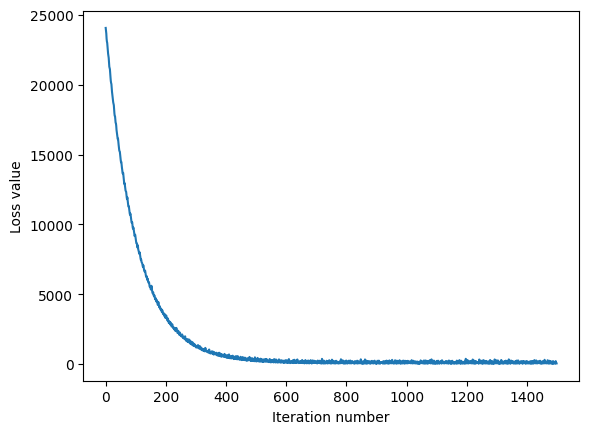

In [22]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [23]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.517642
validation accuracy: 0.508612


In [25]:
# Evaluate the best svm on test set
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.539326


In [26]:
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

learning_rates = [1e-7]
regularization_strengths = [1e-5, 2.5e+4, 5e+4, 7.5e+4, 1e+3, 2.5e+3, 5e+3, 7.5e+3]

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=800, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e-05 train accuracy: 0.260731 val accuracy: 0.267487
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.505682 val accuracy: 0.491740
lr 1.000000e-07 reg 2.500000e+03 train accuracy: 0.450350 val accuracy: 0.442882
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.258052 val accuracy: 0.264323
lr 1.000000e-07 reg 7.500000e+03 train accuracy: 0.259739 val accuracy: 0.265378
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.451293 val accuracy: 0.443937
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.304154 val accuracy: 0.313533
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.450300 val accuracy: 0.442882
best validation accuracy achieved during cross-validation: 0.491740


In [27]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.521067
